In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display


import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [4]:
notes = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Notes:', notes)

Notes: ['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#']


In [5]:
filenames[0:10]

['D:\\magistracy\\diplom\\records_cut\\A\\arpeg-FMaj-060BPM-leg_12.wav',
 'D:\\magistracy\\diplom\\records_cut\\A\\arpeg-FMaj-060BPM-leg_2.wav',
 'D:\\magistracy\\diplom\\records_cut\\A\\arpeg-FMaj-060BPM-leg_5.wav',
 'D:\\magistracy\\diplom\\records_cut\\A\\arpeg-FMaj-060BPM-leg_9.wav',
 'D:\\magistracy\\diplom\\records_cut\\A\\arpeg-FMaj-090BPM-leg_12.wav',
 'D:\\magistracy\\diplom\\records_cut\\A\\arpeg-FMaj-090BPM-leg_2.wav',
 'D:\\magistracy\\diplom\\records_cut\\A\\arpeg-FMaj-090BPM-leg_5.wav',
 'D:\\magistracy\\diplom\\records_cut\\A\\arpeg-FMaj-090BPM-leg_9.wav',
 'D:\\magistracy\\diplom\\records_cut\\A\\arpeg-FMaj-120BPM-leg_12.wav',
 'D:\\magistracy\\diplom\\records_cut\\A\\arpeg-FMaj-120BPM-leg_2.wav']

#### Предварительная проверка файлов на соответствие размеру окна

In [6]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
    # чтобы это работало на графике TensorFlow.
    return parts[-2]

def get_waveform_and_label_check(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label, file_path


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
files_ds = tf.data.Dataset.from_tensor_slices(filenames)
output_ds = files_ds.map(get_waveform_and_label_check, num_parallel_calls=AUTOTUNE)

In [9]:
data = []
lengths = []
for a,b,c in output_ds:
    data.append((a.shape[0],b,c))
    lengths.append(a.shape[0])

In [10]:
idx_yes = [] #список индексов файлов с подходящими размерами
idx_no = [] #список индексов файлов с неподходящими размерами 
for a in range(len(lengths)):
    if lengths[a]<8192:
        idx_no.append(a)
    else:
        idx_yes.append(a)
            
print(len(idx_yes))
print(len(idx_no))
print(len(idx_yes)+len(idx_no))

27310
3518
30828


In [11]:
filenames_filtered = []
for i in range(len(filenames)):
    if i in idx_yes:
        filenames_filtered.append(filenames[i])
len(filenames_filtered)

27310

_______________________

In [12]:
filenames = tf.random.shuffle(filenames_filtered)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/notes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 27310
Number of examples per label: 2318
Example file tensor: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F\\kr033a_150.wav', shape=(), dtype=string)


In [13]:
# Для удобства разбиения выборки на тренировочную, тестовую и валидационную возьмем только 27000 файлов, 
# которые разобьем в соотношении 70:20:10 

filenames = filenames[:27000]

train_files = filenames[:18900]
val_files = filenames[18900: 18900 + 5400]
test_files = filenames[-2700:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 18900
Validation set size 5400
Test set size 2700


In [14]:
# После разделения изначальных аудио-файлов на ноты все получившиеся записи стали моно-записями
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11507, 1])

In [15]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [16]:
def get_spectrogram(params):
    waveform = params[0]
    S = tf.convert_to_tensor(params[1])
    K = 8192
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=K, frame_step=S,fft_length=K,pad_end=True)/np.sqrt(K//2 + 1)
    spectrogram = tf.abs(spectrogram)**2
    return spectrogram


In [17]:
def plot_spectrogram(spectrogram, ax):
    # Преобразуем в частоты для логарифмической шкалы и транспонируем так, чтобы время
    # было представлено на оси x (столбцы). Эпсилон добавляется, чтобы избежать нуля.
    log_spec = np.log(spectrogram.T+np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, width-1, num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [18]:
def get_spectrogram_and_label_id(audio, label, step):
    spectrogram = get_spectrogram((audio,step))
    #spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == notes)
    return spectrogram, label_id

def get_spectrogram_and_label_id_lim(spectrogram, label_id, M):
    spec_length = len(spectrogram)
    if spec_length<M:
        for k in range(M-spec_length):
            spect_last = spectrogram[spec_length-1]
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>M:
        start = tf.random.uniform(shape=[], minval=0, maxval=spec_length-M, dtype=tf.int32)
        spectrogram = spectrogram[start:start+M]
    else:
        spectrogram = spectrogram
    return spectrogram, label_id

In [19]:
def preprocess_dataset(files,s,f):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    #output_ds = output_ds.filter(without_zero_len) 
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,s), num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,f))
    return output_ds

In [20]:
def create_model(input_shape):
    inputs = layers.Input(shape = input_shape, name = "inputs")
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation = 'relu', name = "relu_1")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_2")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_3")(x)
    outputs = layers.Dense(12,activation = 'softmax', name = "dense_end")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [21]:
K = 8192
step = list(map(int,[K/32, K/16, K/8, K/4, K/2, K]))
num_frame = [5,10,15,20,25,30]
params_s_f = [] 

for s in step:
    for f in num_frame:
        params_s_f.append((s,f))
print('Количество вариантов step', len(step))
print('Количество вариантов num_frame', len(num_frame))
print('Количество баз данных', len(params_s_f))

Количество вариантов step 6
Количество вариантов num_frame 6
Количество баз данных 36


In [22]:
import time
EPOCHS = 300
models = []
histories = []

In [23]:
spectrs = [preprocess_dataset(train_files,params_s_f[k][0],params_s_f[k][1]) for k in range(len(params_s_f))]

train_=spectrs
val_ = [preprocess_dataset(val_files,params_s_f[k][0],params_s_f[k][1]) for k in range(len(params_s_f))]
test_ = [preprocess_dataset(test_files,params_s_f[k][0],params_s_f[k][1]) for k in range(len(params_s_f))]
len(spectrs)

36

In [24]:
batch_size = 64

train_ = [t.batch(batch_size) for t in train_]
val_ = [v.batch(batch_size) for v in val_]
train_ = [t.cache().prefetch(AUTOTUNE) for t in train_]
val_ = [v.cache().prefetch(AUTOTUNE) for v in val_]


test_audio_ = []
test_labels_ = []

for t_ds in test_:
    test_audio = []
    test_labels = []
    for audio, label in t_ds:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())
    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)
    test_audio_.append(test_audio)
    test_labels_.append(test_labels)

input_shapes = []    
for s_ds in spectrs:
    for spectrogram, _ in s_ds.take(1):
        input_shapes.append(spectrogram.shape)
print(input_shapes)

[TensorShape([5, 4097]), TensorShape([10, 4097]), TensorShape([15, 4097]), TensorShape([20, 4097]), TensorShape([25, 4097]), TensorShape([30, 4097]), TensorShape([5, 4097]), TensorShape([10, 4097]), TensorShape([15, 4097]), TensorShape([20, 4097]), TensorShape([25, 4097]), TensorShape([30, 4097]), TensorShape([5, 4097]), TensorShape([10, 4097]), TensorShape([15, 4097]), TensorShape([20, 4097]), TensorShape([25, 4097]), TensorShape([30, 4097]), TensorShape([5, 4097]), TensorShape([10, 4097]), TensorShape([15, 4097]), TensorShape([20, 4097]), TensorShape([25, 4097]), TensorShape([30, 4097]), TensorShape([5, 4097]), TensorShape([10, 4097]), TensorShape([15, 4097]), TensorShape([20, 4097]), TensorShape([25, 4097]), TensorShape([30, 4097]), TensorShape([5, 4097]), TensorShape([10, 4097]), TensorShape([15, 4097]), TensorShape([20, 4097]), TensorShape([25, 4097]), TensorShape([30, 4097])]


---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  5
2022-06-08 13:06:14
Epoch 1/100
296/296 [==============================] - 104s 341ms/step - loss: 1.1908 - accuracy: 0.7070 - val_loss: 0.9792 - val_accuracy: 0.7335
Epoch 2/100
296/296 [==============================] - 10s 33ms/step - loss: 0.9048 - accuracy: 0.7422 - val_loss: 0.8875 - val_accuracy: 0.7324
Epoch 3/100
296/296 [==============================] - 10s 33ms/step - loss: 0.8008 - accuracy: 0.7604 - val_loss: 0.8691 - val_accuracy: 0.7424
Epoch 4/100
296/296 [==============================] - 10s 33ms/step - loss: 0.7691 - accuracy: 0.7718 - val_loss: 0.8653 - val_accuracy: 0.7470
Epoch 5/100
296/296 [==============================] - 10s 34ms/step - loss: 0.7007 - accuracy: 0.7835 - val_loss: 0.8658 - val_accuracy: 0.7544
Epoch 6/100
296/296 [==============================] - 10s 34ms/step - loss: 0.6749 - accuracy: 0.7919 - val_loss: 0.8682 - val_accuracy: 0.7544

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная')]

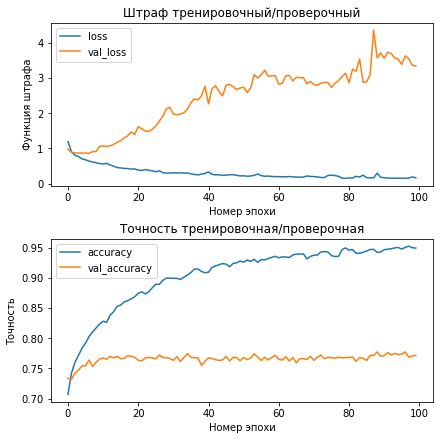

In [25]:
from datetime import datetime

k = 0
print('---------------------------------------------------------------------')
print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

mymodel = create_model(input_shapes[k])

start_time = time.time()
myhistory = mymodel.fit(train_[k], validation_data=val_[k], epochs=EPOCHS, verbose=1)
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio_[k]), axis=1)
y_true = test_labels_[k]
test_acc = sum(y_pred == y_true) / len(y_true) * 100

print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')


fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(myhistory.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(myhistory.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

In [26]:
from datetime import datetime

tests_acc = []
for k in range(6):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    mymodel = create_model(input_shapes[k])
    
    start_time = time.time()
    myhistory = mymodel.fit(train_[k], validation_data=val_[k], epochs=EPOCHS, verbose=0,
                           callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio_[k]), axis=1)
    y_true = test_labels_[k]
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)

---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  5
2022-06-08 14:40:35
--- 4.0 минут 31.456457376480103 секунд ---
85/85 [==============================] - 2s 20ms/step
Шаг: 256 , количество спектрограмм:  5 , accuracy тестовой выборки:  76.18518518518519 %
---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  10
2022-06-08 14:45:08
--- 5.0 минут 39.818708419799805 секунд ---
85/85 [==============================] - 5s 44ms/step
Шаг: 256 , количество спектрограмм:  10 , accuracy тестовой выборки:  80.33333333333333 %
---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  15
2022-06-08 14:50:53
--- 7.0 минут 45.644933462142944 секунд ---
85/85 [==============================] - 9s 86ms/step
Шаг: 256 , количество спектрограмм:  15 , accuracy тестовой выборки:  84.62962962962963 %
------------------------------------------------

ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[259,8192] and type complex64 on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node stft/rfft}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_420466]

In [30]:
k = 5
print('---------------------------------------------------------------------')
print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print(input_shapes[k])
mymodel = create_model(input_shapes[k])

start_time = time.time()
myhistory = mymodel.fit(train_[k], validation_data=val_[k], epochs=EPOCHS, verbose=0,
                       callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio_[k]), axis=1)
y_true = test_labels_[k]
test_acc = sum(y_pred == y_true) / len(y_true) * 100
tests_acc.append(test_acc)
print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
models.append(mymodel)
histories.append(myhistory)

---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  30
2022-06-08 15:16:46
(30, 4097)


ResourceExhaustedError: OOM when allocating tensor with shape[122910,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:RandomUniform]

In [ ]:
for k in range(6):
#for k in range(2):
    metrics = histories[k].history
    fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
    axes[0].plot(histories[k].epoch, metrics['loss'], metrics['val_loss'])
    axes[0].legend(['loss', 'val_loss'])
    axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для {num_frame[k]} спектрограмм')

    axes[1].plot(histories[k].epoch, metrics['accuracy'], metrics['val_accuracy'])
    axes[1].legend(['accuracy', 'val_accuracy'])
    axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для {num_frame[k]} спектрограмм')

In [ ]:

for k in range(6,12):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    mymodel = create_model(input_shapes[k])
    
    start_time = time.time()
    myhistory = mymodel.fit(train_[k], validation_data=val_[k], epochs=EPOCHS, verbose=0,
                           callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio_[k]), axis=1)
    y_true = test_labels_[k]
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)

In [ ]:
for k in range(6,12):
#for k in range(2):
    metrics = histories[k].history
    fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
    axes[0].plot(histories[k].epoch, metrics['loss'], metrics['val_loss'])
    axes[0].legend(['loss', 'val_loss'])
    axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для {num_frame[k]} спектрограмм')

    axes[1].plot(histories[k].epoch, metrics['accuracy'], metrics['val_accuracy'])
    axes[1].legend(['accuracy', 'val_accuracy'])
    axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для {num_frame[k]} спектрограмм')

In [ ]:

for k in range(12,18):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    mymodel = create_model(input_shapes[k])
    
    start_time = time.time()
    myhistory = mymodel.fit(train_[k], validation_data=val_[k], epochs=EPOCHS, verbose=0,
                           callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio_[k]), axis=1)
    y_true = test_labels_[k]
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)

In [ ]:

for k in range(18,24):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    mymodel = create_model(input_shapes[k])
    
    start_time = time.time()
    myhistory = mymodel.fit(train_[k], validation_data=val_[k], epochs=EPOCHS, verbose=0,
                           callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio_[k]), axis=1)
    y_true = test_labels_[k]
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)

In [ ]:

for k in range(24,30):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    mymodel = create_model(input_shapes[k])
    
    start_time = time.time()
    myhistory = mymodel.fit(train_[k], validation_data=val_[k], epochs=EPOCHS, verbose=0,
                           callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio_[k]), axis=1)
    y_true = test_labels_[k]
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)

In [ ]:

for k in range(30,36):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    mymodel = create_model(input_shapes[k])
    
    start_time = time.time()
    myhistory = mymodel.fit(train_[k], validation_data=val_[k], epochs=EPOCHS, verbose=0,
                           callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio_[k]), axis=1)
    y_true = test_labels_[k]
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)

In [ ]:
for k in range(len(num_frame)):
#for k in range(2):
    metrics = histories[k].history
    fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
    axes[0].plot(histories[k].epoch, metrics['loss'], metrics['val_loss'])
    axes[0].legend(['loss', 'val_loss'])
    axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для {num_frame[k]} спектрограмм')

    axes[1].plot(histories[k].epoch, metrics['accuracy'], metrics['val_accuracy'])
    axes[1].legend(['accuracy', 'val_accuracy'])
    axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для {num_frame[k]} спектрограмм')

In [ ]:
# ЗАПАСНОЙ ВЫХОД. БЕЗ НЕОБХОДИМОСТИ НЕ ЗАПУСКАТЬ (ОЧЕНЬ ДОЛГО!)

tests_acc = []
for k in range(len(params_s_f)):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    train_ds = []
    val_ds = []
    test_ds = []
    #spectrogram_ds = waveform_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k][0]), num_parallel_calls=AUTOTUNE)
    #spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k][1]))
    spectrogram_ds = preprocess_dataset(train_files,params_s_f[k][0],params_s_f[k][1])
    train_ds = spectrogram_ds
    val_ds = preprocess_dataset(val_files,params_s_f[k][0],params_s_f[k][1])
    test_ds = preprocess_dataset(test_files,params_s_f[k][0],params_s_f[k][1])
    
    batch_size = 64
    
    train_ds = train_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    
    test_audio = []
    test_labels = []

    for audio, label in test_ds:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())

    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)

    for spectrogram, _ in spectrogram_ds.take(1):
        input_shape = spectrogram.shape
        print('input_shape',input_shape)
    
    
    mymodel = create_model(input_shape)
    
    start_time = time.time()
    myhistory = mymodel.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=0)
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
    y_true = test_labels
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)

In [ ]:
np.array(tests_acc)

In [ ]:
test_acc_mtx = np.zeros((len(step),len(num_frame)))
p = 0
for s in range(len(step)):
    for f in range(len(num_frame)):
        test_acc_mtx[s][f] = tests_acc[p]
        p+=1
plt.figure(figsize=(8, 10))
sns.heatmap(test_acc_mtx, xticklabels=num_frame, yticklabels=step, 
            annot=True, fmt='g')
plt.title('Точность при изменении шага и количества спектрограмм')
plt.xlabel('Количество спектрограмм')
plt.ylabel('Шаг')

In [ ]:
for k in range(len(params_s_f)):
    print(k, params_s_f[k],tests_acc[k])

In [ ]:
k_max = np.argmax(np.array(tests_acc))
k_max

In [ ]:
print('Лучшие параметры: ', params_s_f[k_max][0],params_s_f[k_max][1])

In [ ]:
train_ds = []
val_ds = []
test_ds = []

spectrogram_ds = preprocess_dataset(train_files,params_s_f[k_max][0],params_s_f[k_max][1])
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files,params_s_f[k_max][0],params_s_f[k_max][1])
test_ds = preprocess_dataset(test_files,params_s_f[k_max][0],params_s_f[k_max][1])

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

history_ = histories[k_max]
model_ = models[k_max]
metrics = history_.history

y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100
test_acc

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(history_.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(history_.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

In [ ]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', sample_file)

sample_ds = preprocess_dataset([str(sample_file)],params_s_f[k_max][0],params_s_f[k_max][1])
count = 0 
for spectrogram, label in sample_ds.batch(1):
    count+=1
    prediction = model_(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Предсказание для ноты "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()
print(count)

In [ ]:
# Сохраняем модель
model_.save(r"D:\magistracy\diplom\model\model_stft.h5")

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    
    plot_spectrogram(np.squeeze(spectrogram.numpy()), axes[r][c])
    axes[r][c].set_title(notes[label_id.numpy()])
    axes[r][c].set_ylabel('Номер отсчета')
    axes[r][c].set_xlabel('Номер спектрограммы')


plt.show()

In [ ]:
EPOCHS = [100,10,25,40,50,75]
models1 = [model_]
histories1 = [history_]
tests_acc1 = [test_acc]

for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    print('input_shape',input_shape)

In [ ]:
for k in range(1,len(EPOCHS)):
    print('---------------------------------------------------------------------')

    mymodel = create_model(input_shape)

    start_time = time.time()
    myhistory = mymodel.fit(train_ds, validation_data=val_ds, epochs=EPOCHS[k], verbose=0)
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")

    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
    y_true = test_labels
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc1.append(test_acc)
    print('Эпохи: ',EPOCHS[k], ', accuracy тестовой выборки: ', test_acc, '%')
    models1.append(mymodel)
    histories1.append(myhistory)

In [ ]:
tests_acc1

In [ ]:
k_max1 = np.argmax(np.array(tests_acc1))
k_max1

In [ ]:
history_1 = histories1[k_max1]
model_1 = models1[k_max1]
metrics = history_.history

y_pred = np.argmax(model_1.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100
test_acc

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(history_1.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(history_1.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

In [ ]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', sample_file)

sample_ds = preprocess_dataset([str(sample_file)],params_s_f[k_max1][0],params_s_f[k_max1][1])
count = 0 
for spectrogram, label in sample_ds.batch(1):
    count+=1
    prediction = mymodel(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Предсказание для ноты "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()
print(count)

In [ ]:
# Сохраняем модель
model_1.save(r"D:\magistracy\diplom\model\model_stft.h5")

In [ ]:
model_1.summary()